### Dynamic Time Warping

In [20]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='svg'
import cv2
import json
import pprint

In [21]:
# Specify data-base path
video_path = "RemoBIK.mp4"
data_path = "RemoBIK.data"

# Specify data-compare path
video_path2 = "FemaleBIK.mp4"
data_path2 = "FemaleBIK.data"

#### Leitura dos ângulos

In [22]:
def readAllFramesDATA(file_path):
    keypoints_vec = []
    angles_vec = []
    with open(file_path, 'r') as f:
        for i, line in enumerate(f):
            if i==0:
                metadata = json.loads(line)
            else:
                data = json.loads(line)
                keypoints_vec.append(data["keypoints"])
                angles_vec.append(data["angles"])
    #keypoints_vec = np.array(keypoints_vec).astype(float)
    angles_vec = np.array(angles_vec).astype(float)
    return metadata, angles_vec # return metadata, keypoints_vec, angles_vec

In [23]:
# Import data
metadata, angles_vec = readAllFramesDATA(data_path) # metadata, keypoints_vec, angles_vec = readAllFramesDATA(data_path) 
fps = metadata["fps"]
joint_names = metadata["keypoints_names"]
pairs_names = metadata["keypoints_pairs"]
angles_names = ["Knee <- Ankle -> Ground", "Hip <- Knee -> Ankle", "Shoulder <- Hip -> Knee", "Elbow <- Shoulder -> Hip", "Wrist <- Elbow -> Shoulder"]

# Import data
metadata2, angles_vec2 = readAllFramesDATA(data_path2) # metadata, keypoints_vec, angles_vec = readAllFramesDATA(data_path) 
fps = metadata2["fps"]
joint_names = metadata2["keypoints_names"]
pairs_names = metadata2["keypoints_pairs"]
angles_names = ["Knee <- Ankle -> Ground", "Hip <- Knee -> Ankle", "Shoulder <- Hip -> Knee", "Elbow <- Shoulder -> Hip", "Wrist <- Elbow -> Shoulder"]

In [24]:
# Preview metadata
pprint.pprint(metadata)
pprint.pprint(metadata2)

{'fps': 30,
 'frame_height': 1080,
 'frame_width': 1920,
 'keypoints_names': ['Left Ankle',
                     'Left Knee',
                     'Left Hip',
                     'Left Shoulder',
                     'Left Elbow',
                     'Left Wrist'],
 'keypoints_pairs': [['Left Shoulder', 'Left Elbow'],
                     ['Left Elbow', 'Left Wrist'],
                     ['Left Shoulder', 'Left Hip'],
                     ['Left Hip', 'Left Knee'],
                     ['Left Knee', 'Left Ankle']],
 'n_frames': 616,
 'n_points': 6,
 'summary': 'None',
 'video_name': 'Remo'}
{'fps': 29,
 'frame_height': 338,
 'frame_width': 600,
 'keypoints_names': ['Right Ankle',
                     'Right Knee',
                     'Right Hip',
                     'Right Shoulder',
                     'Right Elbow',
                     'Right Wrist'],
 'keypoints_pairs': [['Right Shoulder', 'Right Elbow'],
                     ['Right Elbow', 'Right Wrist'],
                  

### Plotando ângulos no tempo

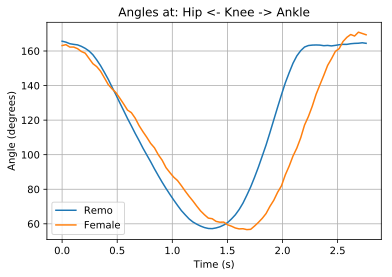

In [25]:
# Plot Angle
joint = "Left Knee" # Joint name
coord = 'x'
if coord == 'x':
    coord_num = 0
else:
    coord_num = 1

angle_name = "Hip <- Knee -> Ankle" # Joint name
angle_vec = angles_vec[:, angles_names.index(angle_name)] # Vertical axis
angle_vec2 = angles_vec2[:, angles_names.index(angle_name)] # Vertical axis
time_vec = np.linspace(0, len(angle_vec)*(1/fps), len(angle_vec)) # Horizontal axis
plt.figure()
plt.plot(time_vec, angle_vec, label = 'Remo')
plt.plot(time_vec, angle_vec2, label = 'Female')
plt.legend(loc='lower left')
plt.title("Angles at: {}".format(angle_name, coord))
plt.ylabel("Angle (degrees)")
plt.xlabel("Time (s)")
plt.grid(True)
plt.show()

### Iniciando Dynamic Time Warping

In [26]:
#Calculates euclidian distances
distances = np.zeros((len(angle_vec), len(angle_vec2))) # same length
for i in range(len(angle_vec2)):
    for j in range(len(angle_vec)):
        distances[i,j] = (angle_vec[j]-angle_vec2[i])**2
#distances

In [27]:
def distance_cost_plot(distances):
    im = plt.imshow(distances, interpolation='nearest', cmap='Purples') 
    plt.gca().invert_yaxis()
    plt.xlabel("Remo")
    plt.ylabel("Female")
    plt.grid()
    plt.colorbar();
#distance_cost_plot(accumulated_cost)

#### Calcula distâncias acumuladas

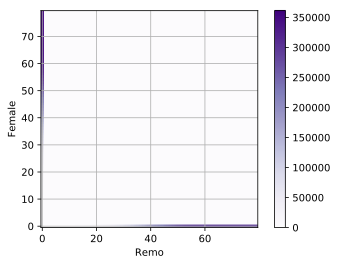

In [28]:
accumulated_cost = np.zeros((len(angle_vec2), len(angle_vec)))

for i in range(1, len(angle_vec)): 
    accumulated_cost[0,i] = distances[0,i] + accumulated_cost[0, i-1]
    for i in range(1, len(angle_vec2)):
        accumulated_cost[i,0] = distances[i, 0] + accumulated_cost[i-1, 0]
distance_cost_plot(accumulated_cost)

#### Procura o menor valor entre três elementos de linha ou coluna anterior

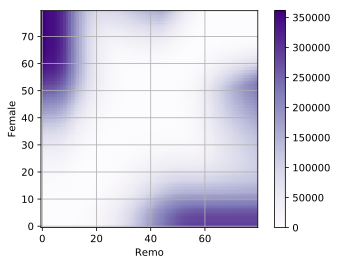

In [29]:
for i in range(1, len(angle_vec2)):
    for j in range(1, len(angle_vec)):
        accumulated_cost[i, j] = min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]) + distances[i, j]
distance_cost_plot(accumulated_cost)

#### Warping path

In [30]:
path = [[len(angle_vec)-1, len(angle_vec2)-1]]
i = len(angle_vec2)-1 
j = len(angle_vec)-1
while i > 0 and j > 0:
    if i == 0:
        j = j - 1
    elif j == 0:
        i = i - 1
    else:
        if accumulated_cost[i-1, j] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
            i = i - 1
        elif accumulated_cost[i, j-1] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
            j = j - 1
        else:
            i = i - 1
            j= j- 1
    path.append([j, i])
path.append([0,0])

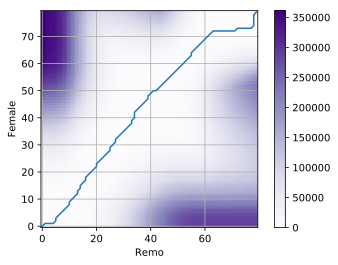

In [31]:
path_x = [point[0] for point in path] # angle_vec
path_z = [point[1] for point in path] # angle_vec2

distance_cost_plot(accumulated_cost)
plt.plot(path_x, path_z);

#### Backtracking warping parth

In [32]:
def path_cost(angle_vec, angle_vec2, accumulated_cost, distances):
    path = [[len(angle_vec)-1, len(angle_vec2)-1]]
    cost = 0
    i = len(angle_vec2)-1
    j = len(angle_vec)-1
    while i > 0 and j > 0:
        if i == 0:
            j = j - 1
        elif j == 0:
            i = i - 1
        else:
            if accumulated_cost[i-1, j] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
                i = i - 1
            elif accumulated_cost[i, j-1] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
                j = j-1
            else:
                i = i - 1
                j= j- 1
        path.append([j, i])
    path.append([0,0])
    for [angle_vec2, angle_vec] in path:
        cost = cost + distances[angle_vec, angle_vec2]
    return path, cost

### Resultado

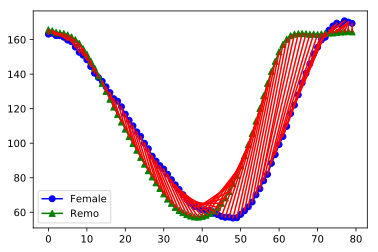

In [33]:
plt.plot(angle_vec2, 'bo-' ,label = 'Female')
plt.plot(angle_vec, 'g^-', label = 'Remo')
plt.legend();
paths = path_cost(angle_vec2, angle_vec, accumulated_cost, distances)[0]
for [map_angle_vec2, map_angle_vec] in paths:
    #print (map_angle_vec2, angle_vec2[map_angle_vec2], ":", map_angle_vec, angle_vec[map_angle_vec])
    
    plt.plot([map_angle_vec2, map_angle_vec], [angle_vec2[map_angle_vec2], angle_vec[map_angle_vec]], 'r')
